In [295]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.regularizers import L1L2
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [296]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [298]:
X_test = np.load("/content/drive/MyDrive/cs/X_test.npy")
y_test = np.load("/content/drive/MyDrive/cs/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/cs/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/cs/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/cs/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/cs/person_test.npy")

print(X_test.shape)
print(y_test.shape)
print(person_train_valid.shape)
print(X_train_valid.shape)
print(y_train_valid.shape)
print(person_test.shape)

y_train_valid -= 769
y_test -= 769

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
person_train, person_valid = person_train_valid[ind_train], person_train_valid[ind_valid]

## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

(443, 22, 1000)
(443,)
(2115, 1)
(2115, 22, 1000)
(2115,)
(443, 1)
Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (69

In [299]:
person_train = np.vstack((person_train, person_train))
person_train = np.vstack((person_train, person_train))
print("Shape of person_train:", person_train.shape)

person_valid = np.vstack((person_valid, person_valid))
person_valid = np.vstack((person_valid, person_valid))
print("Shape of person_valid:", person_valid.shape)

person_test = np.vstack((person_test, person_test))
person_test = np.vstack((person_test, person_test))
print("Shape of person_test:", person_test.shape)

Shape of person_train: (6960, 1)
Shape of person_valid: (1500, 1)
Shape of person_test: (1772, 1)


## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [300]:
def cnn_lstm(time_period=250):
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=1e-3), padding='same', activation='elu', input_shape=(time_period,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=1e-3), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=1e-3), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 4
    hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), kernel_regularizer=L1L2(l1=0, l2=1e-3), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten())
    hybrid_cnn_lstm_model.add(Dense((100)))
    hybrid_cnn_lstm_model.add(Reshape((100,1)))
    hybrid_cnn_lstm_model.add(CuDNNLSTM(25, return_sequences=False))
    hybrid_cnn_lstm_model.add(Dropout(0.5))
    
    hybrid_cnn_lstm_model.add(Dense(4, kernel_regularizer=L1L2(l1=0, l2=1e-3), activation='softmax'))

    # hybrid_cnn_lstm_model.summary()

    return hybrid_cnn_lstm_model

In [301]:
def plot_results(res):
    # Plotting accuracy trajectory
    plt.plot(res.history['accuracy'])
    plt.plot(res.history['val_accuracy'])
    plt.title('Hybrid CNN-LSTM model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plotting loss trajectory
    plt.plot(res.history['loss'],'o')
    plt.plot(res.history['val_loss'],'o')
    plt.title('Hybrid CNN-LSTM model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

def run_model_all():
    model = cnn_lstm()

    learning_rate = 1e-3
    epochs = 50

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

    results = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_valid, y_valid), verbose=True)
    plot_results(results) 

    train_score = model.evaluate(x_train, y_train)
    print('Train accuracy of the hybrid CNN-LSTM model:', train_score[1])

    test_score = model.evaluate(x_test, y_test)
    print('Test accuracy of the hybrid CNN-LSTM model:', test_score[1])

def run_model_s1(train_s1):
    if train_s1:
        x_train_cur = x_train[list(np.where(person_train==0)[0])]
        x_valid_cur = x_valid[list(np.where(person_valid==0)[0])]
        y_train_cur = y_train[list(np.where(person_train==0)[0])]
        y_valid_cur = y_valid[list(np.where(person_valid==0)[0])]
    else:
        x_train_cur, x_valid_cur = x_train, x_valid
        y_train_cur, y_valid_cur = y_train, y_valid
    x_test_cur = x_test[list(np.where(person_test==0)[0])]
    y_test_cur = y_test[list(np.where(person_test==0)[0])]

    model = cnn_lstm()

    learning_rate = 1e-3
    epochs = 50

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

    results = model.fit(x_train_cur, y_train_cur, epochs=epochs, batch_size=64, validation_data=(x_valid_cur, y_valid_cur), verbose=True)
    plot_results(results)

    train_score = model.evaluate(x_train_cur, y_train_cur)
    print('Train accuracy of the hybrid CNN-LSTM model, subject 1:', train_score[1])

    test_score = model.evaluate(x_test_cur, y_test_cur)
    print('Test accuracy of the hybrid CNN-LSTM model, subject 1:', test_score[1])

def run_model_over_time(time_period):
    x_train_cur = x_train[:, :time_period, :, :]
    x_valid_cur = x_valid[:, :time_period, :, :]
    x_test_cur = x_test[:, :time_period, :, :]
    y_train_cur, y_valid_cur, y_test_cur = y_train, y_valid, y_test

    model = cnn_lstm(time_period)

    learning_rate = 1e-3
    epochs = 50

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

    results = model.fit(x_train_cur, y_train_cur, epochs=epochs, batch_size=64, validation_data=(x_valid_cur, y_valid_cur), verbose=True)
    # plot_results(results)

    train_score = model.evaluate(x_train_cur, y_train_cur)
    print('Train accuracy of the hybrid CNN-LSTM model:', train_score[1])

    test_score = model.evaluate(x_test_cur, y_test_cur)
    print('Test accuracy of the hybrid CNN-LSTM model:', test_score[1])

    return train_score, test_score

# Question 1
Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

Epoch 1/50
12/12 [==============================] - 2s 62ms/step - loss: 1.6401 - accuracy: 0.2669 - val_loss: 1.6490 - val_accuracy: 0.2222
Epoch 2/50
12/12 [==============================] - 0s 16ms/step - loss: 1.6046 - accuracy: 0.3060 - val_loss: 1.6634 - val_accuracy: 0.2222
Epoch 3/50
12/12 [==============================] - 0s 21ms/step - loss: 1.5682 - accuracy: 0.3464 - val_loss: 1.7185 - val_accuracy: 0.2222
Epoch 4/50
12/12 [==============================] - 0s 22ms/step - loss: 1.4941 - accuracy: 0.4115 - val_loss: 1.8036 - val_accuracy: 0.2222
Epoch 5/50
12/12 [==============================] - 0s 23ms/step - loss: 1.4304 - accuracy: 0.4128 - val_loss: 1.9577 - val_accuracy: 0.2222
Epoch 6/50
12/12 [==============================] - 0s 21ms/step - loss: 1.3789 - accuracy: 0.4544 - val_loss: 1.9562 - val_accuracy: 0.2222
Epoch 7/50
12/12 [==============================] - 0s 18ms/step - loss: 1.3061 - accuracy: 0.5000 - val_loss: 1.9571 - val_accuracy: 0.2222
Epoch 8/50
12

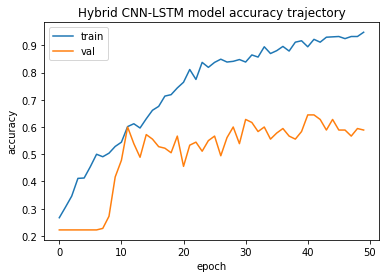

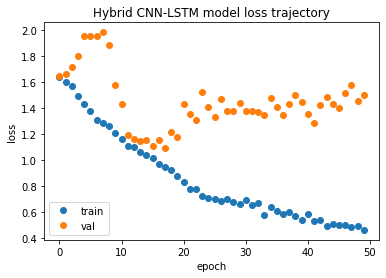

24/24 [==============================] - 0s 6ms/step - loss: 0.3692 - accuracy: 0.9714
Train accuracy of the hybrid CNN-LSTM model, subject 1: 0.9713541865348816
7/7 [==============================] - 0s 17ms/step - loss: 1.8941 - accuracy: 0.5750
Test accuracy of the hybrid CNN-LSTM model, subject 1: 0.574999988079071


In [302]:
## Train/test on subject 1
run_model_s1(train_s1=True)

Epoch 1/50
109/109 [==============================] - 3s 18ms/step - loss: 1.5918 - accuracy: 0.2920 - val_loss: 1.5148 - val_accuracy: 0.3507
Epoch 2/50
109/109 [==============================] - 2s 16ms/step - loss: 1.5015 - accuracy: 0.3693 - val_loss: 1.4002 - val_accuracy: 0.4273
Epoch 3/50
109/109 [==============================] - 1s 13ms/step - loss: 1.4193 - accuracy: 0.4250 - val_loss: 1.3373 - val_accuracy: 0.4760
Epoch 4/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3636 - accuracy: 0.4711 - val_loss: 1.3306 - val_accuracy: 0.4993
Epoch 5/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3242 - accuracy: 0.4825 - val_loss: 1.2975 - val_accuracy: 0.4860
Epoch 6/50
109/109 [==============================] - 1s 11ms/step - loss: 1.2886 - accuracy: 0.4986 - val_loss: 1.2824 - val_accuracy: 0.5040
Epoch 7/50
109/109 [==============================] - 1s 11ms/step - loss: 1.2581 - accuracy: 0.5270 - val_loss: 1.2738 - val_accuracy: 0.5087

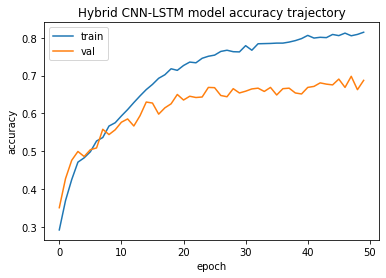

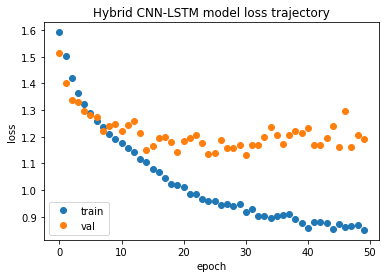

218/218 [==============================] - 2s 7ms/step - loss: 0.4338 - accuracy: 0.9899
Train accuracy of the hybrid CNN-LSTM model, subject 1: 0.9899425506591797
7/7 [==============================] - 0s 7ms/step - loss: 1.6879 - accuracy: 0.5050
Test accuracy of the hybrid CNN-LSTM model, subject 1: 0.5049999952316284


In [303]:
## Train on all, test on subject 1
run_model_s1(train_s1=False)

# Question 2
Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

Epoch 1/50
109/109 [==============================] - 3s 15ms/step - loss: 1.5970 - accuracy: 0.2705 - val_loss: 1.5542 - val_accuracy: 0.3347
Epoch 2/50
109/109 [==============================] - 1s 11ms/step - loss: 1.5197 - accuracy: 0.3421 - val_loss: 1.4528 - val_accuracy: 0.4300
Epoch 3/50
109/109 [==============================] - 1s 11ms/step - loss: 1.4312 - accuracy: 0.4213 - val_loss: 1.3607 - val_accuracy: 0.4567
Epoch 4/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3779 - accuracy: 0.4503 - val_loss: 1.3033 - val_accuracy: 0.4927
Epoch 5/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3344 - accuracy: 0.4743 - val_loss: 1.3272 - val_accuracy: 0.4793
Epoch 6/50
109/109 [==============================] - 2s 14ms/step - loss: 1.2942 - accuracy: 0.4966 - val_loss: 1.2847 - val_accuracy: 0.5107
Epoch 7/50
109/109 [==============================] - 2s 16ms/step - loss: 1.2531 - accuracy: 0.5171 - val_loss: 1.2698 - val_accuracy: 0.5127

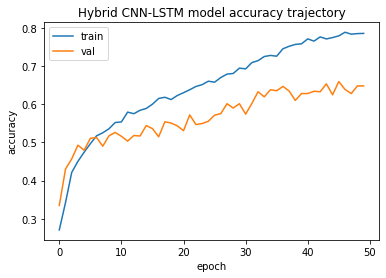

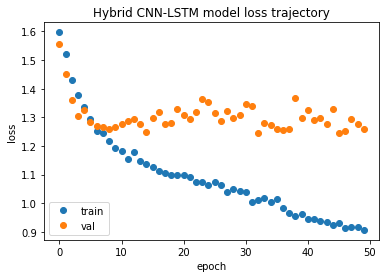

218/218 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.9662
Train accuracy of the hybrid CNN-LSTM model: 0.9662356376647949
56/56 [==============================] - 0s 6ms/step - loss: 1.2765 - accuracy: 0.6716
Test accuracy of the hybrid CNN-LSTM model: 0.6715575456619263


In [304]:
## Train/test on all subjects
run_model_all()

# Question 3
Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? how much time is  equired to get a reasonable classification accuracy?)


Time period 25
Epoch 1/50
109/109 [==============================] - 3s 15ms/step - loss: 1.5099 - accuracy: 0.2704 - val_loss: 1.4791 - val_accuracy: 0.2567
Epoch 2/50
109/109 [==============================] - 1s 10ms/step - loss: 1.4679 - accuracy: 0.2862 - val_loss: 1.4544 - val_accuracy: 0.3227
Epoch 3/50
109/109 [==============================] - 1s 11ms/step - loss: 1.4424 - accuracy: 0.3159 - val_loss: 1.4245 - val_accuracy: 0.3407
Epoch 4/50
109/109 [==============================] - 1s 10ms/step - loss: 1.4174 - accuracy: 0.3464 - val_loss: 1.4184 - val_accuracy: 0.3440
Epoch 5/50
109/109 [==============================] - 1s 12ms/step - loss: 1.3926 - accuracy: 0.3595 - val_loss: 1.3968 - val_accuracy: 0.3653
Epoch 6/50
109/109 [==============================] - 2s 14ms/step - loss: 1.3782 - accuracy: 0.3648 - val_loss: 1.4030 - val_accuracy: 0.3240
Epoch 7/50
109/109 [==============================] - 2s 16ms/step - loss: 1.3734 - accuracy: 0.3777 - val_loss: 1.3773 - val_a

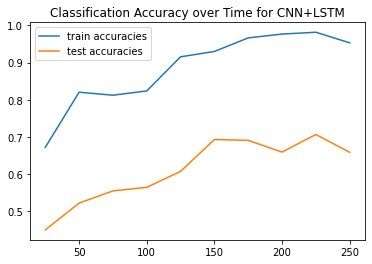

In [305]:
train_scores = []
test_scores = []

for t in range(25, 251, 25):
    print("Time period", t)
    train_score, test_score = run_model_over_time(time_period=t)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])
    print("========================================================================")

print("Train accuracies:", train_scores)
print("Test accuracies:", test_scores)
print("Best accuracy: {}".format(max(test_scores)))
print("Best time period: {}".format(25 * (1 + np.argmax(test_scores))))

plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.title("Classification Accuracy over Time for CNN+LSTM")
plt.legend()
plt.show()